## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Акишин Кирилл Алексеевич

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [ ]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

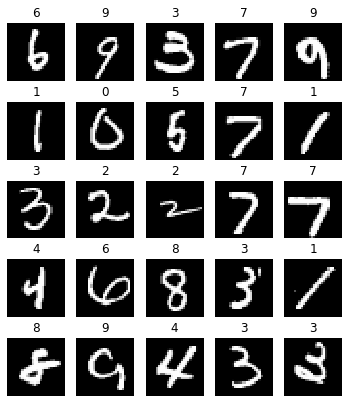

In [8]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [28]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [29]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
#     layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [30]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9888166785240173
forward 0.7088513970375061
forward 0.5805398225784302
forward 0.5047137141227722
forward 0.39620453119277954
forward 0.37610137462615967
forward 0.31880268454551697
forward 0.2707365155220032
forward 0.2122165709733963
forward 0.1821998804807663
forward 0.17639821767807007
forward 0.17118211090564728
forward 0.14465612173080444
forward 0.1470162719488144
forward 0.15239165723323822
forward 0.14006851613521576
forward 0.1161976158618927
forward 0.10915877670049667
forward 0.09243644028902054
forward 0.09851299226284027
forward 0.08463896065950394
forward 0.08113657683134079
forward 0.09427690505981445
forward 0.09068375080823898
forward 0.08796209841966629
forward 0.067196786403656
forward 0.05360449105501175
forward 0.06075587123632431
forward 0.058907296508550644
forward 0.06172570213675499
forward 0.0569266639649868
forward 0.05058013275265694
forward 0.05829774588346481
backward 0.029814239591360092
backward 0.08982010185718536
backward 0.10215897858142853

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [36]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def he_forward(size_input, size_output):
    d = 2 / (size_input)
    return np.sqrt(d)

def he_backward(size_input, size_output):
    d = 2 / (size_output)
    return np.sqrt(d)

In [48]:
# he good forward
init_func = he_forward

layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

66
forward 0.9888166785240173
forward 0.87114417552948
forward 0.9678714871406555
forward 1.044517159461975
forward 1.8193546533584595
forward 1.717124581336975
forward 1.994058609008789
forward 1.589918851852417
forward 1.7165136337280273
forward 2.1189064979553223
forward 1.0491375923156738
forward 0.60286545753479
forward 0.43393659591674805
forward 0.4329237639904022
forward 0.27248135209083557
forward 0.3012445271015167
forward 0.32308000326156616
forward 0.2681889533996582
forward 0.25924819707870483
forward 0.22154967486858368
forward 0.19733864068984985
forward 0.23222514986991882
forward 0.19286327064037323
forward 0.1566230058670044
forward 0.17478559911251068
forward 0.29291942715644836
forward 0.27427050471305847
forward 0.36434805393218994
forward 0.577519953250885
forward 0.6152333617210388
forward 0.46143826842308044
forward 0.33006590604782104
forward 0.26058197021484375
backward 0.029814239591360092
backward 0.06942945718765259
backward 0.07272286713123322
backward 0.0

In [50]:
# he, good backward
init_func = he_backward

layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

66
forward 0.9888166785240173
forward 3.027829647064209
forward 4.310072898864746
forward 4.712921142578125
forward 5.031184673309326
forward 5.214681148529053
forward 6.477756500244141
forward 6.240345478057861
forward 8.145059585571289
forward 3.402435541152954
forward 4.76039457321167
forward 2.9447243213653564
forward 1.3291665315628052
forward 1.266890048980713
forward 1.3222784996032715
forward 0.8278153538703918
forward 0.7150821685791016
forward 0.5787914395332336
forward 0.3959072530269623
forward 0.31626760959625244
forward 0.3687199652194977
forward 0.3444820046424866
forward 0.3945525288581848
forward 0.4806670546531677
forward 0.4822655916213989
forward 0.38995981216430664
forward 0.22060349583625793
forward 0.2508120536804199
forward 0.15324588119983673
forward 0.24100501835346222
forward 0.15410979092121124
forward 0.20860235393047333
forward 0.2642192542552948
backward 0.029814239591360092
backward 0.06552472710609436
backward 0.09657445549964905
backward 0.122163057327

In [53]:
# xavier
init_func = xavier

layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.Tanh())

del layers[-1]

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9888166785240173
forward 0.7067306041717529
forward 0.5606899857521057
forward 0.5151130557060242
forward 0.4279530346393585
forward 0.35524001717567444
forward 0.3260772228240967
forward 0.27758291363716125
forward 0.27272987365722656
forward 0.21055802702903748
forward 0.2340642809867859
forward 0.2015397697687149
forward 0.16961485147476196
forward 0.1533295214176178
forward 0.17983019351959229
forward 0.16254444420337677
forward 0.15973317623138428
forward 0.13035492599010468
forward 0.16483381390571594
forward 0.16933706402778625
forward 0.14078739285469055
forward 0.12165464460849762
forward 0.12484656274318695
forward 0.14289677143096924
forward 0.1254110187292099
forward 0.13295213878154755
forward 0.11593436449766159
forward 0.10549737513065338
forward 0.08822566270828247
forward 0.058545708656311035
forward 0.05582911893725395
forward 0.06798259913921356
forward 0.07327619940042496
backward 0.029814239591360092
backward 0.09542495757341385
backward 0.115880094468593

<i> 1.4 Сделайте выводы по первой части </i>

1. Если $f_{activation}(x) \approx x$, при $x \to 0$, то выгоднее использовать $Xavier$
2. Иначе выгоднее использовать $He$
3. Для увеличения скорости обучения (точнее скорости изменения весов) выгоднее использовать $He_{good backward}$
4. Но противодействовать затуханию/взрыву весов выгоднее с помощью $He_{good forward}$

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [4]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [5]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 14... (Train/Test) NLL: 0.050/0.074	Accuracy: 0.984/0.975


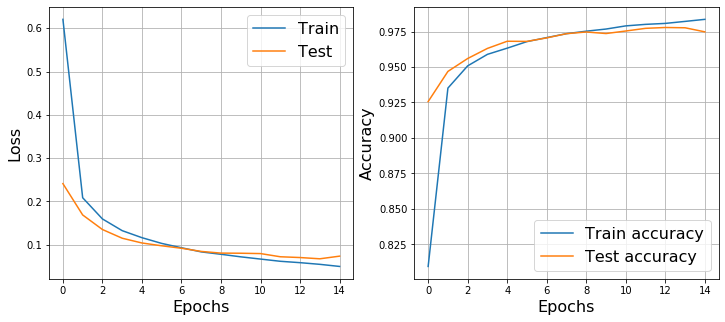

CPU times: user 13min 44s, sys: 44.7 s, total: 14min 29s
Wall time: 7min 21s


([0.6204112659194576,
  0.20850546862969774,
  0.15956009200005644,
  0.13248346032682004,
  0.11626086257366357,
  0.10302280015480925,
  0.09301628016118112,
  0.08343660748446546,
  0.07792385979128608,
  0.07203369009207243,
  0.06686592407461041,
  0.06177441065094428,
  0.05857783354181391,
  0.05473000420156175,
  0.0498590272903911],
 [0.24113394744411298,
  0.16875085347815405,
  0.13511401853418048,
  0.11501259672679479,
  0.10402276164180116,
  0.09753329752461065,
  0.09184846223060843,
  0.08454667300551752,
  0.0806457207927221,
  0.08036749149802365,
  0.07956109012040911,
  0.07221854195776808,
  0.07042397197948981,
  0.06751769113271863,
  0.07365245508808124],
 [0.8094627,
  0.9351513,
  0.9508151,
  0.95892745,
  0.96329176,
  0.967906,
  0.9707211,
  0.97349745,
  0.9752521,
  0.9767569,
  0.9789834,
  0.9800551,
  0.9807325,
  0.98214287,
  0.98358655],
 [0.9256329,
  0.94689476,
  0.9559929,
  0.9631131,
  0.96815664,
  0.96805775,
  0.9705301,
  0.97349685,
  0

In [7]:
%%time

# TestNetwork -> 196 -> 128 -> 10 с ReLU
sizes = [196, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    
    layers.append(layer)
    layers.append(nn.ReLU())
del layers[-1]

from train_utils import train
network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 15, 0.001, device='cpu');

Epoch 14... (Train/Test) NLL: 0.921/0.067	Accuracy: 0.587/0.980


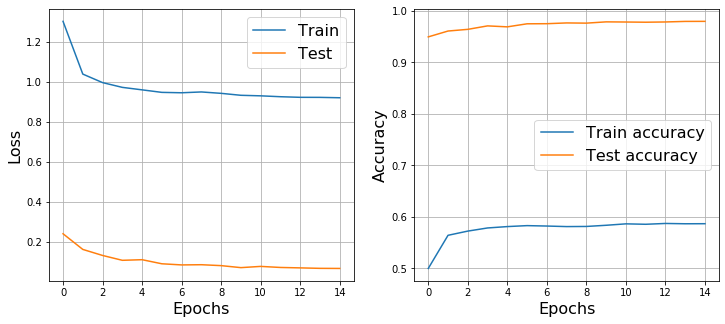

CPU times: user 12min 52s, sys: 37.9 s, total: 13min 30s
Wall time: 6min 48s


([1.303693431781045,
  1.0398539650414798,
  0.9972305407147926,
  0.9734193143814103,
  0.9609831538535892,
  0.9483865421972295,
  0.9464183860241986,
  0.9504941816268954,
  0.9435212319847871,
  0.9337629143363123,
  0.9310833203004621,
  0.9266377953069804,
  0.923629729478344,
  0.9233708642184861,
  0.9214644491799605],
 [0.24102135493031032,
  0.16269720543788957,
  0.1324793101300167,
  0.10819604709933076,
  0.11124632653744915,
  0.09082920137274114,
  0.0851341659509683,
  0.08613327343629885,
  0.08156902576454833,
  0.07154977513783717,
  0.07771903524010242,
  0.07241019458050214,
  0.07029649006980884,
  0.0679793083285795,
  0.0674851176010657],
 [0.49967238,
  0.56404364,
  0.57220596,
  0.5782916,
  0.58096796,
  0.58283365,
  0.5820229,
  0.58096236,
  0.58122337,
  0.58350545,
  0.5862818,
  0.5854489,
  0.58704245,
  0.58644277,
  0.5865483],
 [0.9493671,
  0.96073973,
  0.96400315,
  0.97072786,
  0.9688489,
  0.9747824,
  0.97498024,
  0.9764636,
  0.976068,
  0

In [15]:
%%time

# TestNetwork -> 196 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
sizes = [196, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    
    layers.append(layer)
    layers.append(nn.Dropout(0.5))
    layers.append(nn.ReLU())
del layers[-1]

from train_utils import train
network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 15, 0.001, device='cpu')

Epoch 14... (Train/Test) NLL: 0.168/0.080	Accuracy: 0.946/0.974


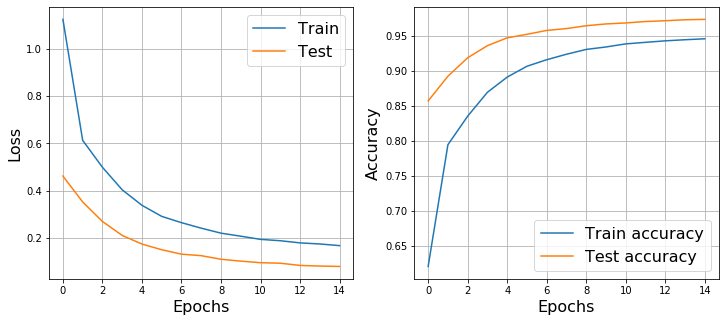

CPU times: user 13min 20s, sys: 42.2 s, total: 14min 2s
Wall time: 7min 5s


([1.1232200709106064,
  0.6126134467404535,
  0.49898260221806673,
  0.40385350645351004,
  0.3384495030588178,
  0.29169266205479594,
  0.2651284711002541,
  0.24193212361351005,
  0.22087658732049248,
  0.20804841864877927,
  0.19469821842303917,
  0.18891882316580713,
  0.17988538355238912,
  0.17522930741500753,
  0.16831017805060852],
 [0.46188238602650317,
  0.3525908598794213,
  0.27021532194523873,
  0.21128993151308614,
  0.1748717197134525,
  0.15092746823837486,
  0.13221914038250718,
  0.12586292409915714,
  0.11072847639693867,
  0.10285519115343879,
  0.09620729720667948,
  0.09407105344005778,
  0.08467238876214132,
  0.08207271668965681,
  0.08041915693615057],
 [0.62079114,
  0.7946817,
  0.8354822,
  0.8696251,
  0.89130247,
  0.90681636,
  0.91612804,
  0.9239628,
  0.9308314,
  0.9343572,
  0.93875486,
  0.94098145,
  0.94310254,
  0.9446795,
  0.94604546],
 [0.8571994,
  0.89260286,
  0.91890824,
  0.9362144,
  0.94738925,
  0.95243275,
  0.95797074,
  0.96064085,


In [13]:
%%time

# TestNetwork -> 196 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев 
sizes = [196, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = DropConnect(size_input, size_output, 0.5)
    
    layers.append(layer)
    layers.append(nn.ReLU())
del layers[-1]

from train_utils import train
network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 15, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

1. В первом случае (без Dropout и DropConnect) сеть быстро переобучается
2. Dropout и DropConnect выступают в роли регуляризации и противодействуют переобучению сети, так как задействованы все нейроны и они менее скоррелированы между собой.
3. При Dropout и DropConnect случай train будет тяжелее случая test

5. Чтобы результат по множеству плохих (с выкинутыми нейронами или весами) моделей был лучше результата одной полной модели, надо чтобы прошло много эпох

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [312]:
# полезные функции: .std(dim), .mean(dim)

class BatchNormalization(nn.Module):
    def forward(self, x):
        output = x.clone()
        mu = output.mean(0) 
        sigma = x.std(0)
        output -= mu
        output *= torch.from_numpy(sigma.detach().numpy())
        return output

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = x.clone()
        mu = output.mean(1) 
        sigma = output.std(1)
        for i in range(x.shape[1]):
            output[:,i] -= mu
            output[:,i] /= torch.from_numpy(sigma.detach().numpy())
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.078/0.074	Accuracy: 0.976/0.976


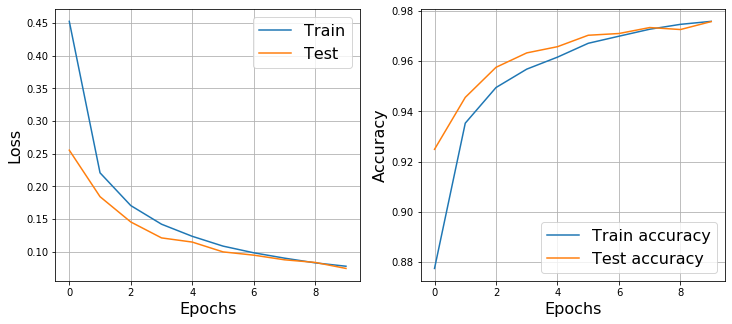

CPU times: user 33min 58s, sys: 1min 5s, total: 35min 3s
Wall time: 17min 56s


([0.45247965539569285,
  0.22072229173773134,
  0.17062319464076048,
  0.14211157819768513,
  0.1235805394521146,
  0.10860176179915476,
  0.09836988325423396,
  0.09017084849112705,
  0.08296462163519758,
  0.07780413057154684],
 [0.25537872059813027,
  0.1842344030737877,
  0.1455307367576074,
  0.1211602222410184,
  0.11477340852157979,
  0.09976295726020125,
  0.09475504279230969,
  0.08765528355784054,
  0.08360390758872786,
  0.0744219220278761],
 [0.8775375,
  0.9353456,
  0.9495269,
  0.9568508,
  0.961626,
  0.9671342,
  0.9699549,
  0.97273123,
  0.97467464,
  0.97586286],
 [0.92494065,
  0.94560915,
  0.95757514,
  0.9633109,
  0.96578324,
  0.97033226,
  0.9710245,
  0.973398,
  0.9726068,
  0.97577137])

In [285]:
%%time

# TestNetwork -> 196 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
sizes = [196, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = LayerNormalization()
    layers.append(layer)
    
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    
    layers.append(nn.ReLU())
del layers[-1]

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.029/0.053	Accuracy: 0.991/0.983


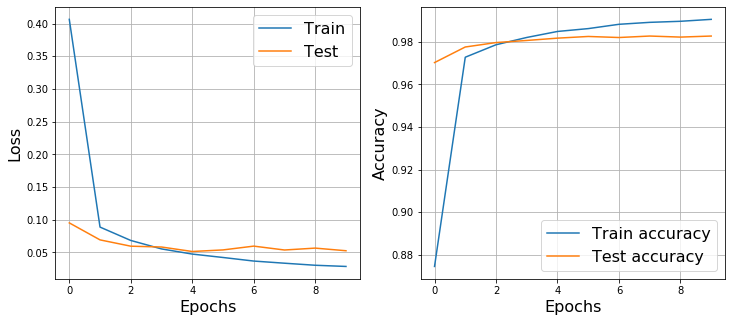

CPU times: user 9min 43s, sys: 16 s, total: 9min 59s
Wall time: 5min 3s


([0.4064784451786961,
  0.08881677263803574,
  0.06838173448427845,
  0.055439428311151104,
  0.0475627878047367,
  0.042346512422467994,
  0.03688378803464753,
  0.03358787282068195,
  0.030448956188307934,
  0.028639563213863066],
 [0.09525040763465664,
  0.06925223043919364,
  0.059622170002777364,
  0.058347902139884576,
  0.051510457338505906,
  0.053907528492368614,
  0.05971380571622543,
  0.05378709780125985,
  0.056672444494140536,
  0.052648245091726886],
 [0.87452805,
  0.97274786,
  0.97860026,
  0.9820263,
  0.98484695,
  0.9861852,
  0.98820627,
  0.98912245,
  0.9896167,
  0.9905273],
 [0.9702334,
  0.9775514,
  0.97962815,
  0.9806171,
  0.9817049,
  0.982496,
  0.9820016,
  0.98269385,
  0.9821994,
  0.98269385])

In [305]:
%%time

# TestNetwork -> 196 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
sizes = [196, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = BatchNormalization()
    layers.append(layer)
    
    layer = nn.Linear(size_input, size_output)
    layers.append(layer)
    
    layers.append(nn.ReLU())
del layers[-1]

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

1. Действительно, нормализация помогает улучшить результаты обучение.
2. Нормализация по батчам в конкретно этом случае работает чуть лучше чем нормализация по нейронам.
3. Но, к сожалению, неудобно использовать нормализацию по батчам в производстве и в исследованиях из-за больших данных и необходимости подбирать новый гиперпараметр.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: